<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Constructing-Typical-Input-for-a-Classifier" data-toc-modified-id="Constructing-Typical-Input-for-a-Classifier-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Constructing Typical Input for a Classifier</a></span><ul class="toc-item"><li><span><a href="#Activation-Maximization" data-toc-modified-id="Activation-Maximization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Activation Maximization</a></span></li><li><span><a href="#Introucing-Typicality" data-toc-modified-id="Introucing-Typicality-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Introucing Typicality</a></span></li></ul></li></ul></div>

# Constructing Typical Input for a Classifier

A classifier learns to extract certain information from input. Therefore, it builds hidden features. In this notebook, we want to examine what pattern these features are sensitive to.

## Activation Maximization
One way to do it is to define a target pattern $p$ for a layer $l$ and find input $X$ that maximally activates the dot product of it's activation and the pattern $ l(X)^T p $. This can be done via gradient descent.


In [1]:
%matplotlib inline
from cifar10_utils import *
net = Net()
net.load("cifar10net")
accuracy = net.accuracy(testloader)
print("Accuracy:", accuracy)

Files already downloaded and verified
Files already downloaded and verified
Accuracy: 0.5268


Since we want to visualize typical patterns for hidden features, we need a visualization method at some point.
So we might as well visualize some images now

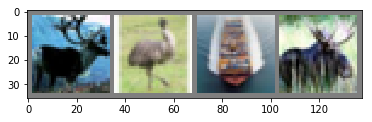

 deer  bird  ship  deer


In [20]:
# functions to show an image
def imshow(X):
    img = torchvision.utils.make_grid(X)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:4], labels[:4]

# show images
imshow(images)
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

As for the LRP implementation, it is again convenient to layerize the network. That gives us an easy way to inspect features of different layers.

0 3.8736910820007324
1000 0.6775739192962646
2000 0.3981252610683441
3000 0.29655250906944275
4000 0.2449469417333603
5000 0.21303337812423706
6000 0.19146105647087097
7000 0.17538194358348846
8000 0.16269393265247345
9000 0.1523885875940323
10000 0.14385616779327393
11000 0.13661091029644012
12000 0.1303723156452179
13000 0.12492857128381729
14000 0.12011914700269699
15000 0.11583078652620316
16000 0.11194639652967453
17000 0.10839983820915222
18000 0.10514813661575317
19000 0.10214952379465103
20000 0.0993882492184639
21000 0.09683166444301605
22000 0.09444396197795868
23000 0.09221692383289337
24000 0.09012703597545624
25000 0.08817078173160553
26000 0.08633121848106384
27000 0.08459774404764175
28000 0.08296918123960495
29000 0.08142450451850891
30000 0.07994592189788818
31000 0.07853511720895767
32000 0.07719370722770691
33000 0.07591249793767929
34000 0.07469099014997482
35000 0.07352511584758759
36000 0.07240469008684158
37000 0.07133468985557556
38000 0.07031258195638657
39000 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


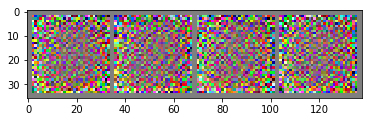

In [43]:
from layerized_net import *
from torch import nn
from torch.nn import functional as F
import numpy as np

na = None

class AMLayer(Layer):
    def compute_stats(self, X):
        pass
   
class Relu():
    def forward(self, x):
        self.a = super().forward(x)
        return F.relu(self.a)
    
class Linear(AMLayer, nn.Linear):
    """
    For linear layers without Relu activation, usually the last
    """
    def forward(self, x):
        D = np.prod(x.shape[1:])
        x = x.view(-1, D)
        return super().forward(x)
  
class LinearRelu(Relu, Linear):
    pass

class ConvRelu(AMLayer, Relu, nn.Conv2d):
    pass

class MaxPool(AMLayer, Relu, nn.MaxPool2d):
    pass


class AMNet(LayerizedNet):
    def forward_until(self, layer, x, a=False):
        # forward until specified layer
        for layer in self.layers[:layer+1]:
            x = layer.forward(x)
        return layer.a if a else x
    
    def zeros_like(self, layer, samples):
        return self.forward_until(2, samples[0][na,...])*0
            
    def activation_maximization(self, layer, pattern, sample, steps=2000, lr=0.1):
        # generate some initial noise
        am = torch.from_numpy(np.random.normal(0*sample)).float()
        am.requires_grad_(True)
                
        # define the loss function and the optimizer
        criterion = torch.nn.MSELoss()
        optimizer = optim.SGD([am], lr=lr, momentum=0.5)

        def step():
            outputs = self.forward_until(layer, am, a=True)
            optimizer.zero_grad()
            loss = criterion(outputs, pattern.detach())
            loss.backward()
            optimizer.step()
            return loss
        
        train_loss = []
        for i in range(steps):
            train_loss += [float(step())]
            if i % 1000 == 0:
                print(i, train_loss[-1])
            if i > 100 and np.mean(train_loss[-20:-10]) <= np.mean(train_loss[-10:]):
                break

        return am
    
    
amnet = AMNet.from_model(
    model=net,
    layer_names=['conv1', 'pool', 'conv2', 'pool', 'fc1', 'fc2', 'fc3'],
    layer_base_type=Relu, last_layer_type=Linear)

pattern = amnet.zeros_like(2, images)
c = 0
pattern[0,c, 5, 5] = 1
am = amnet.activation_maximization(layer=2, pattern=pattern, sample=images*0, steps=300000)
imshow(am.detach())

In [42]:
amnet.forward_until(2, am)[0,c, 5, 5]

tensor(0.0802, grad_fn=<SelectBackward>)

## Introucing Typicality
This process has no notion of typicality. Since we have not learned the pdf of $X$, this is hard - but maybe we can introduce a regularization that finds input, that also activates the hidden activations in a typical manner. We estimate the typicality of an activation by a Gaussian distribution with learned mean and variance.

Therefore, we need to collect these static for each neuron.